# **SetUp**

In [1]:
!nvidia-smi

Fri Feb 20 20:03:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:10:1C.0 Off |                    0 |
| N/A   52C    P0             69W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **ZO**

实验层级配置

L0 Baseline（默认）
- `BATCHDIFF_CKPT = -1`
- 按 `SAVE_STEPS` 固定频率保存**完整 checkpoint**

L1 Batch Differential Checkpoint
- `BATCHDIFF_CKPT = 0`：Incremental（从 base 开始累积所有 updates）
- `BATCHDIFF_CKPT = 1`：Pure Differential（只保存当前 step 的 update）
- `BATCHDIFF_CKPT = N (N >= 2)`：Batch Differential（每 `N` 步生成一次新的 full checkpoint）
对于 batch_size >= 2 (Batch Differential 模式):

save_full_model=False (默认):

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
只保存 batch_diff_meta.pt 和 zo_replay_history.json（空的）
不保存 model.safetensors 或 pytorch_model.bin
恢复时从初始缓存模型开始，replay 所有差分 checkpoint
save_full_model=True:

每 N 步：更新 base_checkpoint_state（内存），清空 update_history
保存 batch_diff_meta.pt、zo_replay_history.json 和完整的模型文件
恢复时可以从最近的完整 checkpoint 开始，减少 replay 的步数

L2 CPU Shadow
- `ENABLE_SHADOW = 1`
- 依赖：`BATCHDIFF_CKPT >= 0`
- CPU 端实时维护 **shadow model**

L3 即时恢复
- `INSTANT_RECOVER = 1`
- 依赖：`L2 + GPU_FAIL_STEP`
- 故障后立即恢复

GPU 故障注入（旁路）
- `GPU_FAIL_STEP = N`
- 在第 `N` 步模拟 GPU 故障
- 可单独使用

In [9]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_6 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=100 DO_EVAL=0 \
    bash /home/users/u0001609/NonStopZO2/example/mezo_runner/mezo.sh

========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 100
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: -1 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --no_eval 


2026-02-20 06:12:58,513 - INFO - NumExpr defaulting to 16 threads.
2026-02-20 06:12:59,564 - INFO - PyTorch version 2.9.0 available.
[2026-02-20 06:13:11,530] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2026-02-20 06:13:17,455] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=-1,
batchdiff_resume=,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloa

In [25]:
# diff
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_staging_9 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=1 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 1
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --batchdiff_ckpt 0 --no_eval 
2026-02-20 22:01:39,466 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=0,
batchdiff_resume=,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader

# **Resume**

Resume / Replay
- If BATCHDIFF_CKPT=-1 用 RESUME_CKPT 走 HuggingFace 标准恢复
- `BATCHDIFF_RESUME`
- 从指定的 full checkpoint 恢复，自动扫描并重放后续的 differential checkpoints
- BATCHDIFF_REPLAY_DEVICE=cuda参数（cpu 或 cuda）

In [11]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_4 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=100 DO_EVAL=0 \
    BATCHDIFF_CKPT=-1\
    RESUME_CKPT="/home/ubuntu/ZO_ckpt/Test_staging_7-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 100
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: -1 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: 
Extra args:  --resume_from_checkpoint /home/ubuntu/ZO_ckpt/Test_staging_7-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-100 --no_eval 
2026-02-21 04:52:01,740 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
batchdiff_ckpt=-1,
batchdiff_

In [12]:
# 简单staging
!MODEL=Qwen/Qwen3-1.7B \
    TRAIN_NAME=Test_resume_4 TASK=SST2 MODE=ft LR=1e-7 EPS=1e-3 \
    STEPS=1000 EVAL_STEPS=100 SAVE_STEPS=100 DO_EVAL=0 \
    BATCHDIFF_CKPT=0 BATCHDIFF_REPLAY_DEVICE=cpu\
    BATCHDIFF_RESUME="/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-1" \
    bash /home/ubuntu/NonStopZO2/example/mezo_runner/mezo.sh

Using GPU: 0
========== Configuration ==========
TAG: mezo-ft-1e-7-1e-3-0
BS: 16, LR: 1e-7, EPS: 1e-3, SEED: 0
STEPS: 1000, EVAL_STEPS: 100, SAVE_STEPS: 100
MODE: ft, DO_EVAL: 0
--- Batch Differential Checkpoint ---
BATCHDIFF_CKPT: 0 (-1=disabled, 0=incremental, 1=pure diff, N>=2=batch diff)
ENABLE_SHADOW: 0
INSTANT_RECOVER: 0
GPU_FAIL_STEP: -1
BATCHDIFF_RESUME: /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-1
Extra args:  --batchdiff_ckpt 0 --batchdiff_resume /home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-1 --no_eval 
2026-02-21 04:54:26,807 - INFO - PyTorch version 2.10.0 available.
OurArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False

# **Read CKPT**

In [20]:
import torch
import json

# 读取 .pt 文件
# pt_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_5-SST2-Qwen3-1.7B-mezo-ft-1e-6-1e-4-0/checkpoint-100/scheduler.pt"
pt_path = "/home/ubuntu/ZO_ckpt/Test_staging_8-SST2-Qwen3-1.7B-mezo-ft-1e-7-1e-3-0/checkpoint-5/batch_diff_meta.pt"
meta = torch.load(pt_path, map_location='cpu', weights_only=True)
print("=== scheduler.pt ===")
print(meta)

# # 读取 .json 文件
# json_path = "/lvs0/rccs-hpbdrt/minqiu/ZO_ckpt/Test_staging_4-SST2-Qwen3-1.7B-mezo-ft-1e-6-1e-4-0/checkpoint-200/zo_replay_history.json"
# with open(json_path, 'r') as f:
#     history = json.load(f)
# print("\n=== zo_replay_history.json ===")
# print(history)

=== scheduler.pt ===
{'base_checkpoint': None, 'step': 5, 'is_batch_diff': True, 'is_full_checkpoint': False, 'batch_size': 1, 'num_updates': 0}


In [16]:
import os
from safetensors.torch import load_file

path = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00001-of-00002.safetensors"
assert os.path.exists(path), f"File not found: {path}"

state = load_file(path)  # dict: name -> torch.Tensor

print("Loaded:", path)
print("Num tensors:", len(state))

# Show a quick summary (first ~40 tensors)
for i, (k, v) in enumerate(state.items()):
    print(f"{i:03d}  {k:60s}  shape={tuple(v.shape)}  dtype={v.dtype}  device={v.device}")

Loaded: /home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00001-of-00002.safetensors
Num tensors: 310
000  model.embed_tokens.weight                                     shape=(151936, 2048)  dtype=torch.bfloat16  device=cpu
001  model.layers.0.input_layernorm.weight                         shape=(2048,)  dtype=torch.bfloat16  device=cpu
002  model.layers.0.mlp.down_proj.weight                           shape=(2048, 6144)  dtype=torch.bfloat16  device=cpu
003  model.layers.0.mlp.gate_proj.weight                           shape=(6144, 2048)  dtype=torch.bfloat16  device=cpu
004  model.layers.0.mlp.up_proj.weight                             shape=(6144, 2048)  dtype=torch.bfloat16  device=cpu
005  model.layers.0.post_attention_layernorm.weight                shape=(2048,)  dtype=torch.bfloat16  device=cpu
006  model.layers.0.self_attn.k_norm.weight                        shape=(128,)  dtype=torch.bfloat16  device=cpu
007 

In [17]:
import torch
from safetensors.torch import load_file

state = load_file(path)
path1 = "/home/ubuntu/.cache/huggingface/hub/models--Qwen--Qwen3-1.7B/snapshots/70d244cc86ccca08cf5af4e1e306ecf908b1ad5e/model-00002-of-00002.safetensors"
state1 = load_file(path1)

w_lm = state1["lm_head.weight"]
w_emb = state["model.embed_tokens.weight"]

print("lm_head.weight:", tuple(w_lm.shape), w_lm.dtype, w_lm.device)
print("model.embed_tokens.weight:", tuple(w_emb.shape), w_emb.dtype, w_emb.device)

same_shape = (w_lm.shape == w_emb.shape)
same_dtype = (w_lm.dtype == w_emb.dtype)

# exact equality + closeness
exact_equal = torch.equal(w_lm, w_emb)
max_abs_diff = (w_lm - w_emb).abs().max().item() if same_shape else None
allclose = torch.allclose(w_lm, w_emb, rtol=0.0, atol=0.0) if same_shape else False

print("\nSame shape:", same_shape)
print("Same dtype:", same_dtype)
print("torch.equal:", exact_equal)
print("max|diff|:", max_abs_diff)
print("allclose(atol=0, rtol=0):", allclose)

# If you want a more tolerant check too:
if same_shape:
    print("allclose(atol=1e-6, rtol=1e-6):", torch.allclose(w_lm, w_emb, atol=1e-6, rtol=1e-6))

lm_head.weight: (151936, 2048) torch.bfloat16 cpu
model.embed_tokens.weight: (151936, 2048) torch.bfloat16 cpu

Same shape: True
Same dtype: True
torch.equal: True
max|diff|: 0.0
allclose(atol=0, rtol=0): True
allclose(atol=1e-6, rtol=1e-6): True


# **Evaluate**

In [26]:
!python3 /home/ubuntu/NonStopZO2/experiments/analyze_checkpoint_time.py \
    /home/ubuntu/NonStopZO2/experiments/incremental.log \
    -v    # 显示每个checkpoint的详细信息


Checkpoint Time Analysis
Log file: /home/ubuntu/NonStopZO2/experiments/incremental.log
Total checkpoints:  1000
Average time:       0.0043s
Median time:        0.0042s
Standard deviation: 0.0019s
Min time:           0.0009s
Max time:           0.0135s
Total time spent:   4.2689s

Individual checkpoint times:
--------------------------------------------------
  Step      1 [   Differential]: 0.0010s
  Step      2 [   Differential]: 0.0009s
  Step      3 [   Differential]: 0.0010s
  Step      4 [   Differential]: 0.0010s
  Step      5 [   Differential]: 0.0009s
  Step      6 [   Differential]: 0.0010s
  Step      7 [   Differential]: 0.0010s
  Step      8 [   Differential]: 0.0010s
  Step      9 [   Differential]: 0.0027s
  Step     10 [   Differential]: 0.0010s
  Step     11 [   Differential]: 0.0010s
  Step     12 [   Differential]: 0.0010s
  Step     13 [   Differential]: 0.0011s
  Step     14 [   Differential]: 0.0010s
  Step     15 [   Differential]: 0.0010s
  Step     16 [   Differ

# **Plot**

In [13]:
"""
ZO Checkpoint 成本模型 — 可交互画图脚本
=======================================
使用方法：
  1. 在下方 Cell 1 中填入你的实验数据
  2. 运行整个脚本，会自动生成所有图表
  3. 图表保存在脚本同目录下
"""

# ╔══════════════════════════════════════════════════════════════╗
# ║  Cell 1：在这里输入你的实验数据                                ║
# ╚══════════════════════════════════════════════════════════════╝

# ---------- 基本参数 ----------
TOTAL_STEPS = 1000          # 总训练步数

# ---------- 你测到的各种 checkpoint 模式 ----------
# 格式说明：每个模式是一个字典，包含：
#   name:              模式名称（显示在图上）
#   avg_ckpt_time:     单次 checkpoint 平均耗时（秒）
#   total_ckpts:       总共做了多少次 checkpoint
#   e2e_time_seconds:  端到端训练时间（秒）
#   color:             画图颜色（可选，不填会自动分配）

checkpoint_modes = [
    {
        "name": "Full Checkpoint",
        "avg_ckpt_time": 19.758,
        "total_ckpts": 10,
        "e2e_time_seconds": 7 * 60 + 12,   # 7分12秒
        "color": "#e74c3c",
    },
    {
        "name": "Differential (WAL)",
        "avg_ckpt_time": 0.0009,
        "total_ckpts": 1000,
        "e2e_time_seconds": 6 * 60 + 0,    # 6分0秒
        "color": "#3498db",
    },
    {
        "name": "Incremental",
        "avg_ckpt_time": 0.0043,
        "total_ckpts": 1000,
        "e2e_time_seconds": 6 * 60 + 4,    # 6分4秒
        "color": "#2ecc71",
    },
]

# ---------- 恢复时间数据 ----------
# 格式：每个条目是一个字典
#   name:       恢复模式名称
#   load_base:  加载基础权重的时间（秒）
#   replay_steps: 回放了多少步
#   replay_time:  回放这些步的总时间（秒）
#   device:     "CPU" 或 "GPU"

resume_measurements = [
    # Full checkpoint 直接加载
    {"name": "Full Checkpoint",   "load_base": 1.126, "replay_steps": 0,  "replay_time": 0,       "device": "GPU"},
    # Differential - GPU
    {"name": "Differential (GPU)","load_base": 0.628, "replay_steps": 1,  "replay_time": 2.130,   "device": "GPU"},
    {"name": "Differential (GPU)","load_base": 0.638, "replay_steps": 10, "replay_time": 2.846,   "device": "GPU"},
    # Differential - CPU
    {"name": "Differential (CPU)","load_base": 0.638, "replay_steps": 1,  "replay_time": 12.354,  "device": "CPU"},
    {"name": "Differential (CPU)","load_base": 0.640, "replay_steps": 10, "replay_time": 127.750, "device": "CPU"},
    # Incremental - GPU
    {"name": "Incremental (GPU)", "load_base": 0.6424,"replay_steps": 10, "replay_time": 2.8585,  "device": "GPU"},
    # Incremental - CPU
    {"name": "Incremental (CPU)", "load_base": 0.6449,"replay_steps": 10, "replay_time": 126.1925,"device": "CPU"},
]

# ---------- 成本模型参数 ----------
# C: 做一次全量 anchor 的时间（秒）—— 通常就是 Full checkpoint 的时间
C = 19.758

# U: 回放一步的时间（秒/步）
# 建议用 GPU 分摊值（replay_time / replay_steps，取多步的测量值）
U_primary = 0.285       # GPU 分摊值（主要用这个）
U_secondary = 2.13      # GPU 冷启动值（用于对比）
U_primary_label = "GPU 分摊 (U=0.285s)"
U_secondary_label = "GPU 冷启动 (U=2.13s)"

# load_base: 加载基础权重的时间
LOAD_BASE = 0.638

# step_time: 每步训练时间（用纯训练的 E2E 时间 / 总步数）
# 建议用开销最小的模式（Differential）的 E2E 时间
STEP_TIME = (6 * 60) / TOTAL_STEPS   # 0.36 秒

# MTBF 范围（小时），用于画图
MTBF_RANGE_HOURS = (0.5, 24)   # 从 0.5 小时到 24 小时

# 要在表格中展示的 MTBF 值（小时）
MTBF_TABLE_VALUES = [1, 2, 4, 8, 12, 24]

# 画图输出路径（不含后缀，会自动加 .png）
OUTPUT_PREFIX = "zo_checkpoint"

ZO Checkpoint 成本模型 — 计算结果

【输入参数】
  C (全量 anchor 时间)       = 19.758s
  U_primary (主要回放成本)    = 0.285s/step  (GPU 分摊 (U=0.285s))
  U_secondary (对比回放成本)  = 2.130s/step  (GPU 冷启动 (U=2.13s))
  每步训练时间               ≈ 0.360s
  加载基础权重时间            = 0.638s

【最优 Anchor 间隔 K* = √(2CM/U)】
MTBF(h)    K*(primary)     K*(secondary)   Overhead%       恢复时间(s)        
----------------------------------------------------------------------
1          707             258             15.5            101.3          
2          999             365             11.0            143.0          
4          1413            517             7.8             202.0          
8          1998            731             5.5             285.4          
12         2447            895             4.5             349.4          
24         3461            1266            3.2             493.9          

【各 Checkpoint 模式写入开销对比】
  Full Checkpoint              10 次 × 19.7580s = 197.6s 总开销
  Differential (WAL)         1000 次 × 0

/tmp/ipykernel_36243/2359380577.py:135: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_36243/2359380577.py:135: UserWarning: Glyph 25674 (\N{CJK UNIFIED IDEOGRAPH-644A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_36243/2359380577.py:135: UserWarning: Glyph 20919 (\N{CJK UNIFIED IDEOGRAPH-51B7}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_36243/2359380577.py:135: UserWarning: Glyph 21551 (\N{CJK UNIFIED IDEOGRAPH-542F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/tmp/ipykernel_36243/2359380577.py:135: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=2.0)
/home/ubuntu/.miao/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

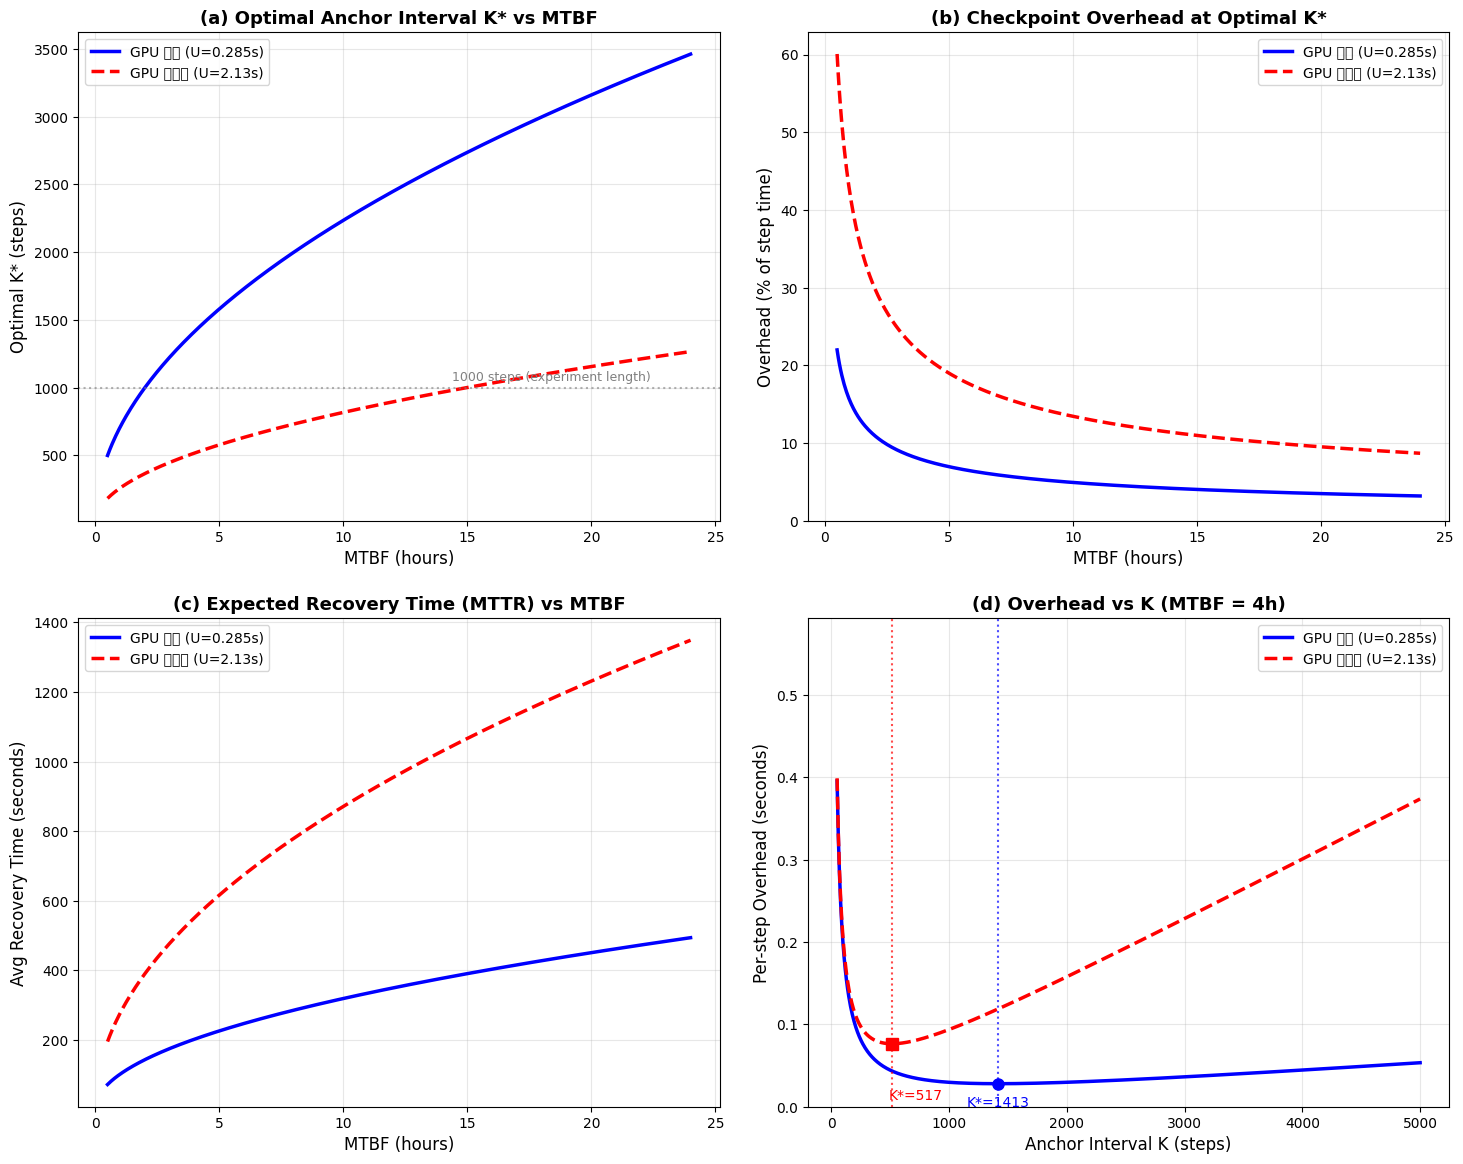

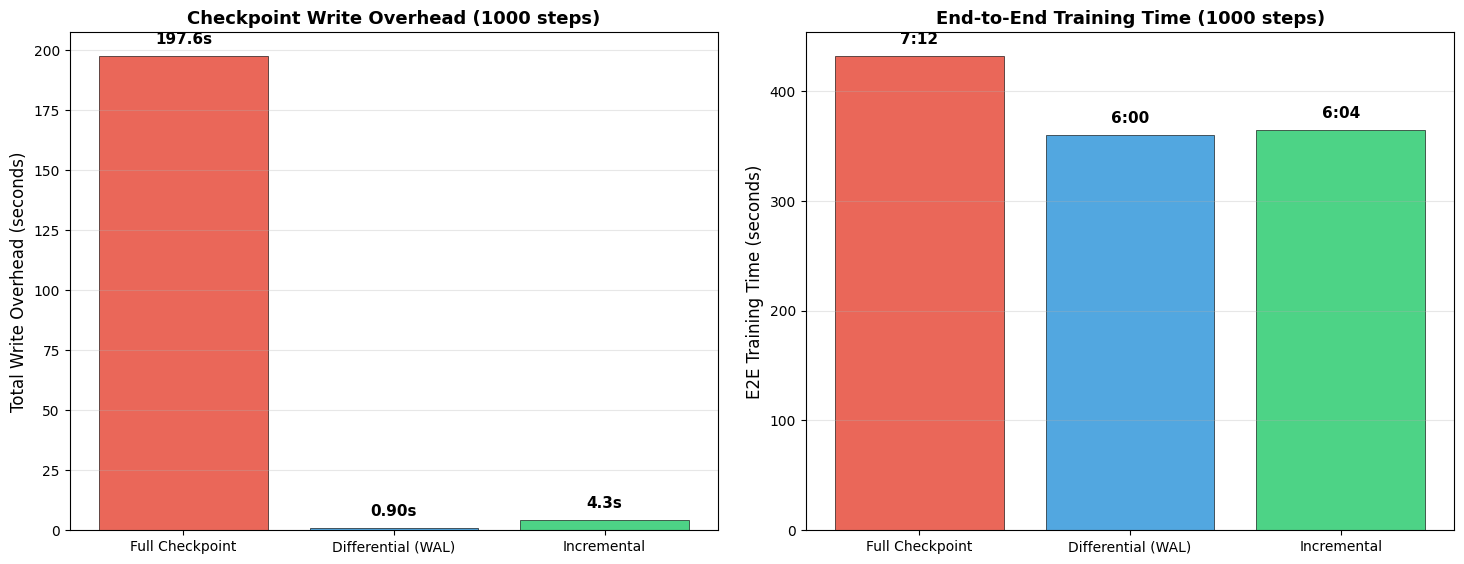

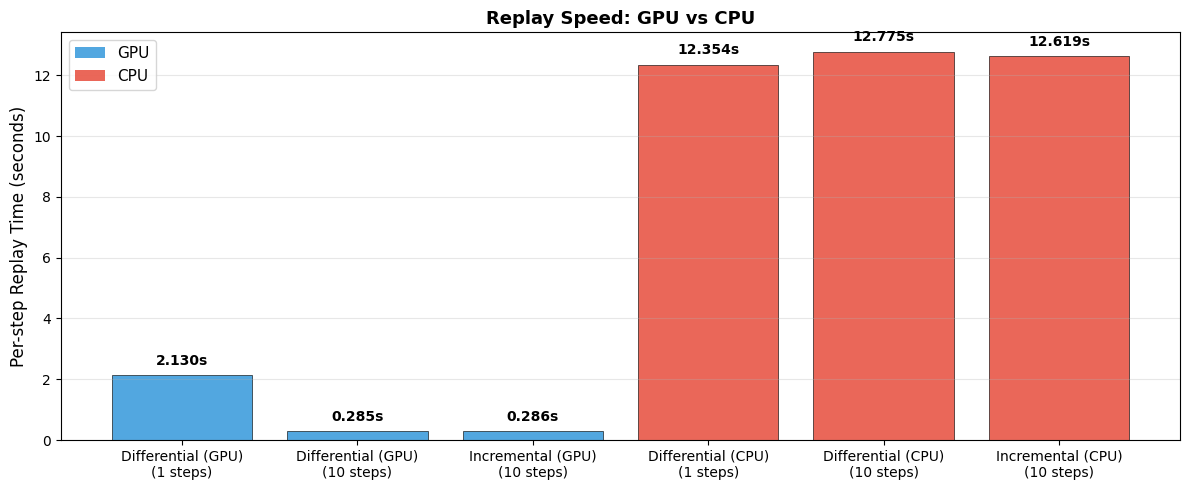


所有图表已生成完毕！


In [16]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Cell 2：以下是计算和画图代码，一般不需要修改                      ║
# ╚══════════════════════════════════════════════════════════════╝

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# 设置中文字体（如果系统有的话）
for font_name in ['SimHei', 'WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'PingFang SC', 'Microsoft YaHei']:
    try:
        matplotlib.font_manager.findfont(font_name, fallback_to_default=False)
        plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
        break
    except:
        continue
plt.rcParams['axes.unicode_minus'] = False

# ---------- 自动计算 ----------
print("=" * 70)
print("ZO Checkpoint 成本模型 — 计算结果")
print("=" * 70)

print(f"\n【输入参数】")
print(f"  C (全量 anchor 时间)       = {C:.3f}s")
print(f"  U_primary (主要回放成本)    = {U_primary:.3f}s/step  ({U_primary_label})")
print(f"  U_secondary (对比回放成本)  = {U_secondary:.3f}s/step  ({U_secondary_label})")
print(f"  每步训练时间               ≈ {STEP_TIME:.3f}s")
print(f"  加载基础权重时间            = {LOAD_BASE:.3f}s")

# K* 计算
print(f"\n【最优 Anchor 间隔 K* = √(2CM/U)】")
print(f"{'MTBF(h)':<10} {'K*(primary)':<15} {'K*(secondary)':<15} {'Overhead%':<15} {'恢复时间(s)':<15}")
print("-" * 70)
for mh in MTBF_TABLE_VALUES:
    ms = mh * 3600
    k1 = np.sqrt(2 * C * ms / U_primary)
    k2 = np.sqrt(2 * C * ms / U_secondary)
    overhead_pct = 2 * np.sqrt(C * U_primary / (2 * ms)) / STEP_TIME * 100
    recovery = LOAD_BASE + (k1 / 2) * U_primary
    print(f"{mh:<10} {k1:<15.0f} {k2:<15.0f} {overhead_pct:<15.1f} {recovery:<15.1f}")

# Checkpoint 模式对比
print(f"\n【各 Checkpoint 模式写入开销对比】")
for mode in checkpoint_modes:
    total_overhead = mode["avg_ckpt_time"] * mode["total_ckpts"]
    print(f"  {mode['name']:<25} {mode['total_ckpts']:>5} 次 × {mode['avg_ckpt_time']:.4f}s = {total_overhead:.1f}s 总开销")

# 回放速度
print(f"\n【回放速度测量值】")
for r in resume_measurements:
    if r["replay_steps"] > 0:
        per_step = r["replay_time"] / r["replay_steps"]
        print(f"  {r['name']:<25} {r['replay_steps']:>3} steps → {r['replay_time']:.3f}s  (每步 {per_step:.3f}s)")
    else:
        print(f"  {r['name']:<25} 直接加载 → {r['load_base']:.3f}s")

# ╔══════════════════════════════════════════════════════════════╗
# ║  Cell 3：画图                                                ║
# ╚══════════════════════════════════════════════════════════════╝

mtbf_hours = np.linspace(MTBF_RANGE_HOURS[0], MTBF_RANGE_HOURS[1], 500)
mtbf_seconds = mtbf_hours * 3600

# ========== 图1：四合一分析图 ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- 1a: K* vs MTBF ---
ax = axes[0, 0]
K1 = np.sqrt(2 * C * mtbf_seconds / U_primary)
K2 = np.sqrt(2 * C * mtbf_seconds / U_secondary)
ax.plot(mtbf_hours, K1, 'b-', linewidth=2.5, label=U_primary_label)
ax.plot(mtbf_hours, K2, 'r--', linewidth=2.5, label=U_secondary_label)
ax.axhline(y=TOTAL_STEPS, color='gray', linestyle=':', alpha=0.6)
ax.annotate(f'{TOTAL_STEPS} steps (experiment length)', xy=(MTBF_RANGE_HOURS[1]*0.6, TOTAL_STEPS*1.05),
            fontsize=9, color='gray')
ax.set_xlabel('MTBF (hours)', fontsize=12)
ax.set_ylabel('Optimal K* (steps)', fontsize=12)
ax.set_title('(a) Optimal Anchor Interval K* vs MTBF', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- 1b: Overhead % vs MTBF ---
ax = axes[0, 1]
oh1 = 2 * np.sqrt(C * U_primary / (2 * mtbf_seconds)) / STEP_TIME * 100
oh2 = 2 * np.sqrt(C * U_secondary / (2 * mtbf_seconds)) / STEP_TIME * 100
ax.plot(mtbf_hours, oh1, 'b-', linewidth=2.5, label=U_primary_label)
ax.plot(mtbf_hours, oh2, 'r--', linewidth=2.5, label=U_secondary_label)
ax.set_xlabel('MTBF (hours)', fontsize=12)
ax.set_ylabel('Overhead (% of step time)', fontsize=12)
ax.set_title('(b) Checkpoint Overhead at Optimal K*', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

# --- 1c: Recovery time vs MTBF ---
ax = axes[1, 0]
rec1 = LOAD_BASE + (K1 / 2) * U_primary
rec2 = LOAD_BASE + (K2 / 2) * U_secondary
ax.plot(mtbf_hours, rec1, 'b-', linewidth=2.5, label=U_primary_label)
ax.plot(mtbf_hours, rec2, 'r--', linewidth=2.5, label=U_secondary_label)
ax.set_xlabel('MTBF (hours)', fontsize=12)
ax.set_ylabel('Avg Recovery Time (seconds)', fontsize=12)
ax.set_title('(c) Expected Recovery Time (MTTR) vs MTBF', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- 1d: overhead(K) 曲线，选一个 MTBF 展示最优点 ---
ax = axes[1, 1]
mtbf_demo = 4  # 默认用 4 小时做展示
mtbf_demo_s = mtbf_demo * 3600
K_range = np.linspace(50, 5000, 1000)
ovh1 = C / K_range + U_primary * K_range / (2 * mtbf_demo_s)
ovh2 = C / K_range + U_secondary * K_range / (2 * mtbf_demo_s)
K_opt1 = np.sqrt(2 * C * mtbf_demo_s / U_primary)
K_opt2 = np.sqrt(2 * C * mtbf_demo_s / U_secondary)
ax.plot(K_range, ovh1, 'b-', linewidth=2.5, label=U_primary_label)
ax.plot(K_range, ovh2, 'r--', linewidth=2.5, label=U_secondary_label)
ax.axvline(x=K_opt1, color='blue', linestyle=':', alpha=0.7)
ax.axvline(x=K_opt2, color='red', linestyle=':', alpha=0.7)
ax.plot(K_opt1, C/K_opt1 + U_primary*K_opt1/(2*mtbf_demo_s), 'bo', markersize=8)
ax.plot(K_opt2, C/K_opt2 + U_secondary*K_opt2/(2*mtbf_demo_s), 'rs', markersize=8)
ax.annotate(f'K*={K_opt1:.0f}', xy=(K_opt1, 0), fontsize=10, color='blue',
            ha='center', va='bottom', xytext=(K_opt1, -0.003))
ax.annotate(f'K*={K_opt2:.0f}', xy=(K_opt2, 0), fontsize=10, color='red',
            ha='center', va='bottom', xytext=(K_opt2+200, 0.005))
ax.set_xlabel('Anchor Interval K (steps)', fontsize=12)
ax.set_ylabel('Per-step Overhead (seconds)', fontsize=12)
ax.set_title(f'(d) Overhead vs K (MTBF = {mtbf_demo}h)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0, top=max(ovh2.max() * 0.5, ovh1.max() * 1.5))

plt.tight_layout(pad=2.0)
plt.show()

# ========== 图2：策略对比柱状图 ==========
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# 自动分配颜色
default_colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c', '#e67e22', '#34495e']
for i, mode in enumerate(checkpoint_modes):
    if "color" not in mode:
        mode["color"] = default_colors[i % len(default_colors)]

# --- 2a: 写入开销 ---
ax = axes2[0]
names = [m["name"] for m in checkpoint_modes]
overheads = [m["avg_ckpt_time"] * m["total_ckpts"] for m in checkpoint_modes]
colors = [m["color"] for m in checkpoint_modes]
bars = ax.bar(names, overheads, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, overheads):
    label = f'{val:.1f}s' if val >= 1 else f'{val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(overheads)*0.02,
            label, ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Total Write Overhead (seconds)', fontsize=12)
ax.set_title(f'Checkpoint Write Overhead ({TOTAL_STEPS} steps)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# --- 2b: E2E 时间 ---
ax = axes2[1]
e2e_times = [m["e2e_time_seconds"] for m in checkpoint_modes]
bars = ax.bar(names, e2e_times, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)
for bar, val in zip(bars, e2e_times):
    m, s = divmod(int(val), 60)
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(e2e_times)*0.02,
            f'{m}:{s:02d}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('E2E Training Time (seconds)', fontsize=12)
ax.set_title(f'End-to-End Training Time ({TOTAL_STEPS} steps)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout(pad=2.0)
plt.show()

# ========== 图3：回放速度对比 ==========
fig3, ax3 = plt.subplots(figsize=(12, 5))

# 按设备分组
gpu_data = [r for r in resume_measurements if r["device"] == "GPU" and r["replay_steps"] > 0]
cpu_data = [r for r in resume_measurements if r["device"] == "CPU" and r["replay_steps"] > 0]

if gpu_data or cpu_data:
    all_replay = gpu_data + cpu_data
    labels = [f"{r['name']}\n({r['replay_steps']} steps)" for r in all_replay]
    per_step = [r["replay_time"] / r["replay_steps"] for r in all_replay]
    bar_colors = ['#3498db' if r["device"] == "GPU" else '#e74c3c' for r in all_replay]
    
    bars = ax3.bar(labels, per_step, color=bar_colors, alpha=0.85, edgecolor='black', linewidth=0.5)
    for bar, val in zip(bars, per_step):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(per_step)*0.02,
                f'{val:.3f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 图例
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', alpha=0.85, label='GPU'),
                       Patch(facecolor='#e74c3c', alpha=0.85, label='CPU')]
    ax3.legend(handles=legend_elements, fontsize=11)
    ax3.set_ylabel('Per-step Replay Time (seconds)', fontsize=12)
    ax3.set_title('Replay Speed: GPU vs CPU', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"所有图表已生成完毕！")
print(f"{'='*70}")